In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.datasets import Planetoid
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import networkx as nx
import math

In [2]:
class SearchSpace:
    def __init__(self):
        # self.layer_types = ['GCN', 'GAT', 'GraphSAGE', 'ChebNet', 'GIN', 'GraphConv', 'SplineConv']
        self.layer_types = ['GraphSAGE', 'GCN', 'GAT']
        self.activation_functions = ['relu', 'sigmoid', 'tanh', 'leaky_relu', 'elu']
        self.num_layers_range = range(1, 4) 
    
    def sample_architecture(self):
        """
        Randomly samples an architecture from the search space.
        """
        # num_layers = random.randint(1, 3)  # Choose between 1 and 3 layers
        num_layers = 3
        architecture = {
            'layers': [random.choice(self.layer_types) for _ in range(num_layers)],
            'activations': [random.choice(self.activation_functions) for _ in range(num_layers)]
        }
        return architecture


In [3]:
class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features, activation):
        super(GCNLayer, self).__init__()
        self.gcn = GCNConv(in_features, out_features)
        self.activation = getattr(F, activation)

    def forward(self, x, edge_index):
        x = self.gcn(x, edge_index)
        return self.activation(x)

class GATLayer(nn.Module):
    def __init__(self, in_features, out_features, activation):
        super(GATLayer, self).__init__()
        self.gat = GATConv(in_features, out_features)
        self.activation = getattr(F, activation)

    def forward(self, x, edge_index):
        x = self.gat(x, edge_index)
        return self.activation(x)

class GraphSAGELayer(nn.Module):
    def __init__(self, in_features, out_features, activation):
        super(GraphSAGELayer, self).__init__()
        self.graphsage = SAGEConv(in_features, out_features)
        self.activation = getattr(F, activation)

    def forward(self, x, edge_index):
        x = self.graphsage(x, edge_index)
        return self.activation(x)

class GraphNeuralNetwork(nn.Module):
    def __init__(self, architecture, input_dim, hidden_dim, output_dim):
        super(GraphNeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()
        in_features = input_dim

        for layer_type, activation in zip(architecture['layers'], architecture['activations']):
            if layer_type == 'GCN':
                layer = GCNLayer(in_features, hidden_dim, activation)
            elif layer_type == 'GAT':
                layer = GATLayer(in_features, hidden_dim, activation)
            elif layer_type == 'GraphSAGE':
                layer = GraphSAGELayer(in_features, hidden_dim, activation)
            elif layer_type == 'ChebNet':
                layer = ChebNetLayer(in_features, hidden_dim, activation)
            elif layer_type == 'GIN':
                layer = GINLayer(in_features, hidden_dim, activation)
            elif layer_type == 'GraphConv':
                layer = GraphConvLayer(in_features, hidden_dim, activation)
            elif layer_type == 'SplineConv':
                layer = SplineConvLayer(in_features, hidden_dim, activation)
                
            self.layers.append(layer)
            in_features = hidden_dim

        # Final layer
        self.final_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        for layer in self.layers:
            x = layer(x, edge_index)
        return F.log_softmax(self.final_layer(x), dim=1)


# # Example of creating a GNN model with the sampled architecture
# input_dim = 1433  # Example input dimension for Cora dataset
# hidden_dim = 64   # As discussed earlier
# output_dim = 7    # Number of classes in Cora dataset

# gnn_model = GraphNeuralNetwork(sampled_architecture, input_dim, hidden_dim, output_dim)
# gnn_model  # Display the created model


In [4]:
def train_gnn(model, data, optimizer, criterion, epochs=50):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
    
    return model


def evaluate_gnn(model, data, metric_fn):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        predictions = out.argmax(dim=1)
        correct = predictions[data.test_mask] == data.y[data.test_mask]
        accuracy = metric_fn(correct.float())  # Преобразование в float
    
    return accuracy.item()

In [6]:
class ReinforcementLearner:
    def __init__(self, architecture_generator, learning_rate=0.01):       
        self.generator = architecture_generator
        self.optimizer = torch.optim.Adam(self.generator.parameters(), lr=learning_rate)
        self.reward_history = []

    def update_generator(self, rewards, architectures, log_probs_list):
        self.optimizer.zero_grad()
        rewards = [torch.tensor(reward, requires_grad=True) for reward in rewards]  # Добавляем градиенты к наградам
        log_probs_list = [torch.tensor(log_prob, requires_grad=True) for log_prob in log_probs_list]  # Добавляем градиенты к лог-вероятностям
        loss = -torch.mean(torch.stack([reward * log_prob for reward, log_prob in zip(rewards, log_probs_list)]))
        loss.backward()
        self.optimizer.step()
        
        average_reward = sum(rewards) / len(rewards)
        self.reward_history.append(average_reward)
        
        for reward, architecture in zip(rewards, architectures):
            layer_type_index = self.generator.search_space.layer_types.index(architecture['layers'][0])
            activation_index = self.generator.search_space.activation_functions.index(architecture['activations'][0])
            self.generator.update_layer_probs(layer_type_index, reward, self.reward_history)
            self.generator.update_activation_probs(activation_index, reward, self.reward_history)
        print(f'layer_probs: {self.generator.layer_probs}')
        print(f'activation_probs: {self.generator.activation_probs}')
                
        # print(loss,' ' ,self.generator.parameters)

In [7]:
def load_dataset():
    # In practice, this function would load the dataset from a file or other source,
    # preprocess it (e.g., normalize features, create train/test masks), and return it.
    # Since we don't have the actual dataset here, we'll return a placeholder.
    data = Planetoid(root='./dataset/Cora', name='Cora')
    return data

data = load_dataset()


In [8]:
data.num_classes

7

In [9]:
# Шаг 2: Генерация Архитектур
search_space = SearchSpace()
sampled_architecture = search_space.sample_architecture()

# Шаг 3: Создание Модели GNN
input_dim = data.num_node_features
hidden_dim = 64   # Как обсуждалось ранее
output_dim = data.num_classes
gnn_model = GraphNeuralNetwork(sampled_architecture, input_dim, hidden_dim, output_dim)

# Шаг 4: Обучение Модели GNN
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
trained_model = train_gnn(gnn_model, data, optimizer, criterion)

# Шаг 5: Оценка Модели GNN
accuracy = evaluate_gnn(trained_model, data, torch.mean)
print("Accuracy:", accuracy)


Accuracy: 0.7120000123977661


In [18]:
class ArchitectureGenerator(nn.Module):
    def __init__(self, search_space, hidden_size=64):
        super(ArchitectureGenerator, self).__init__()
        self.search_space = search_space
        self.layer_types = search_space.layer_types
        self.activation_functions = search_space.activation_functions
        self.hidden_size = hidden_size
        self.layer_probs = [1.0 / len(self.layer_types)] * len(self.layer_types)
        self.activation_probs = [1.0 / len(self.activation_functions)] * len(self.activation_functions)
        num_choices_per_layer = len(search_space.layer_types) + len(search_space.activation_functions)
        
        # LSTM для генерации архитектур
        self.rnn = nn.LSTM(input_size=num_choices_per_layer, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_choices_per_layer)

    def forward(self, x, hidden=None):
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        log_probs = torch.log_softmax(out, dim=-1)  # Логарифмы вероятностей выбора каждого элемента
        return log_probs, hidden
    
    def generate(self, current_state=None):
        # Выбор первого слоя на основе текущих вероятностей
        layer_type_index_1 = torch.multinomial(torch.tensor(self.layer_probs), 1).item()
        layer_type_1 = self.layer_types[layer_type_index_1]
    
        # Выбор первой функции активации на основе текущих вероятностей
        activation_index_1 = torch.multinomial(torch.tensor(self.activation_probs), 1).item()
        activation_1 = self.activation_functions[activation_index_1]
    
        # Выбор второго слоя на основе текущих вероятностей
        layer_type_index_2 = torch.multinomial(torch.tensor(self.layer_probs), 1).item()
        layer_type_2 = self.layer_types[layer_type_index_2]
    
        # Выбор второй функции активации на основе текущих вероятностей
        activation_index_2 = torch.multinomial(torch.tensor(self.activation_probs), 1).item()
        activation_2 = self.activation_functions[activation_index_2]
    
        # Строим архитектуру из двух слоев
        architecture = {'layers': [layer_type_1, layer_type_2], 'activations': [activation_1, activation_2]}
        
        # Вычисляем логарифм вероятности выбора этой архитектуры
        log_prob = torch.tensor([math.log(self.layer_probs[layer_type_index_1]) + math.log(self.activation_probs[activation_index_1]) + 
                                math.log(self.layer_probs[layer_type_index_2]) + math.log(self.activation_probs[activation_index_2])])
    
        return log_prob, architecture, current_state


    def update_layer_probs(self, layer_type_index, reward, reward_history):
        prev_reward = reward_history[-1] if reward_history else 0.0
        if reward > prev_reward:
            self.layer_probs[layer_type_index] *= 1.1  # Например, можно увеличить на 10%
        else:
            self.layer_probs[layer_type_index] *= 0.9  # Например, можно уменьшить на 10%
        total_prob = sum(self.layer_probs)
        self.layer_probs = [p / total_prob for p in self.layer_probs]
    
    def update_activation_probs(self, activation_index, reward, reward_history):
        prev_reward = reward_history[-1]
        if prev_reward==reward:
            return
        if reward > prev_reward:
            self.activation_probs[activation_index] *= 1.1  # Например, можно увеличить на 10%
        else:
            self.activation_probs[activation_index] *= 0.99  # Например, можно уменьшить на 10%
        total_prob = sum(self.activation_probs)
        self.activation_probs = [p / total_prob for p in self.activation_probs]



search_space = SearchSpace()
architecture_generator = ArchitectureGenerator(search_space)  # Создание генератора архитектур
reinforcement_learner = ReinforcementLearner(architecture_generator)  # Создание ученика с подкреплением

In [36]:
num_iterations = 30  # Количество итераций обновления
batch_size = 3       # Количество архитектур для генерации и оценки на каждой итерации
best_architecture = None
best_accuracy = 0.0
loss_history = []
accuracy_history = []

for iteration in tqdm(range(num_iterations)):
    architectures = []
    rewards = []
    log_probs_list = []

    # Генерация и оценка архитектур
    for _ in range(batch_size):
        # Генерация архитектуры и логарифмы вероятностей
        log_probs, architecture, _= reinforcement_learner.generator.generate()
        log_probs_list.append(log_probs)
        architectures.append(architecture)

        # Создание и обучение модели GNN
        gnn_model = GraphNeuralNetwork(architecture, input_dim, hidden_dim, output_dim)
        optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
        criterion = torch.nn.CrossEntropyLoss()
        trained_model = train_gnn(gnn_model, data, optimizer, criterion)

        # Оценка модели GNN и получение награды
        accuracy = evaluate_gnn(trained_model, data, torch.mean)
        loss = criterion(trained_model(data.x, data.edge_index)[data.train_mask], data.y[data.train_mask])
        loss_history.append(loss.item())
       
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_architecture = architecture
        rewards.append(accuracy)
    accuracy_history.append(max(rewards))
        

    # Обновление генератора архитектур
    reinforcement_learner.update_generator(rewards, architectures, log_probs_list)

    # Вывод прогресса
    print(f"Iteration {iteration + 1}/{num_iterations}, Average Reward: {sum(rewards)/len(rewards)}")


  0%|          | 0/30 [00:00<?, ?it/s]

C:\Users\MSI-NOTEbook\AppData\Local\Temp\ipykernel_21724\2201317203.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_probs_list = [torch.tensor(log_prob, requires_grad=True) for log_prob in log_probs_list]  # Добавляем градиенты к лог-вероятностям


layer_probs: [0.17290755958812468, 0.7903902510709016, 0.03670218934097373]
activation_probs: [0.0028124383841014945, 0.0013700071627255853, 0.935444382819225, 0.05874560312462991, 0.001627568509317994]
Iteration 1/30, Average Reward: 0.7693333427111307
layer_probs: [0.18842955492952237, 0.7752095699356395, 0.03636087513483822]
activation_probs: [0.0020115784525334673, 0.0009798888053633697, 0.9538270103107226, 0.042017414530608865, 0.0011641079007716824]
Iteration 2/30, Average Reward: 0.7676666577657064
layer_probs: [0.1762681701856583, 0.7897177128210474, 0.03401411699329422]
activation_probs: [0.0014307622635055329, 0.0006969591085943997, 0.9671588392898889, 0.029885451917000996, 0.0008279874210101462]
Iteration 3/30, Average Reward: 0.7703333298365275
layer_probs: [0.16469275990499627, 0.8035268069206152, 0.031780433174388535]
activation_probs: [0.0010135584813992914, 0.0004937289958805317, 0.9767351726937679, 0.021170989781846408, 0.0005865500471060712]
Iteration 4/30, Average Re

In [37]:
def visualize_architecture(architecture):
    G = nx.Graph()
    
    layers = architecture['layers']
    activations = architecture['activations']
    
    for i, layer in enumerate(layers):
        G.add_node(f"Layer {i+1}", type="Layer", label=layer)
        if i > 0:
            G.add_edge(f"Layer {i}", f"Layer {i+1}", type="Connection")
    
    for i, activation in enumerate(activations):
        G.add_node(f"Activation {i+1}", type="Activation", label=activation)
        G.add_edge(f"Layer {i+1}", f"Activation {i+1}", type="Connection")
    
    pos = nx.spring_layout(G, seed=42)
    
    node_labels = {node: data['label'] for node, data in G.nodes(data=True)}
    node_colors = [('blue' if data['type'] == 'Layer' else 'green') for _, data in G.nodes(data=True)]
    
    nx.draw(G, pos, node_size=500, node_color=node_colors, labels=node_labels, with_labels=True, font_size=8)
    plt.show()


def plot_training_metrics(loss_history, accuracy_history):
    # Создаем график функции потерь
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(loss_history, label='Loss', color='r')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    # Создаем график точности
    plt.subplot(1, 2, 2)
    plt.plot(accuracy_history, label='Accuracy', color='b')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
# best_architecture = None
# best_accuracy = 0.0
# loss_history = []
# accuracy_history = []

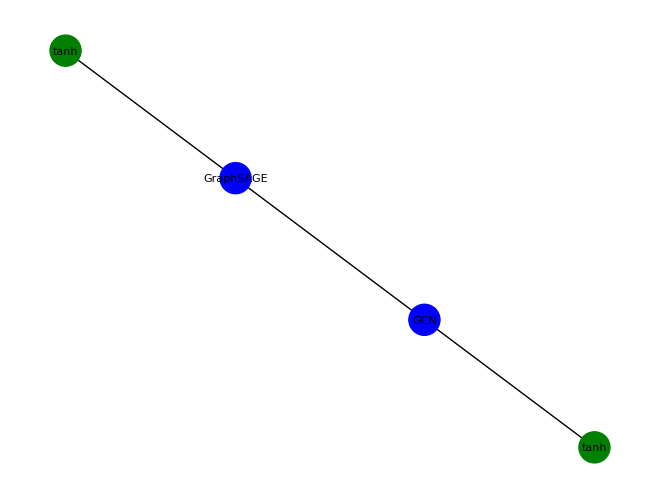

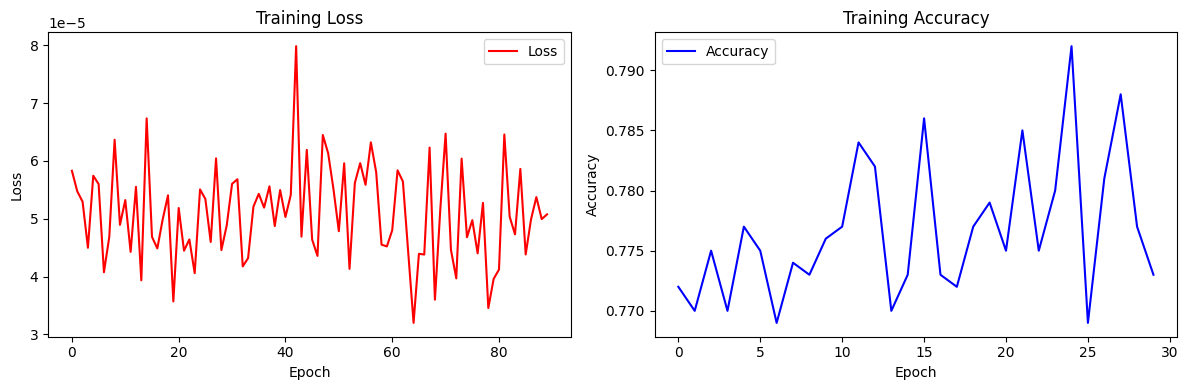

In [38]:
visualize_architecture(best_architecture)
plot_training_metrics(loss_history, accuracy_history)

In [22]:
def moving_average(data, window_size):
    moving_avg = []
    for i in range(len(data)):
        start = max(0, i - window_size + 1)
        end = i + 1
        window = data[start:end]
        avg = sum(window) / len(window)
        moving_avg.append(avg)
    return moving_avg

In [65]:
smoothed_accuracy = moving_average(accuracy_history, 5)

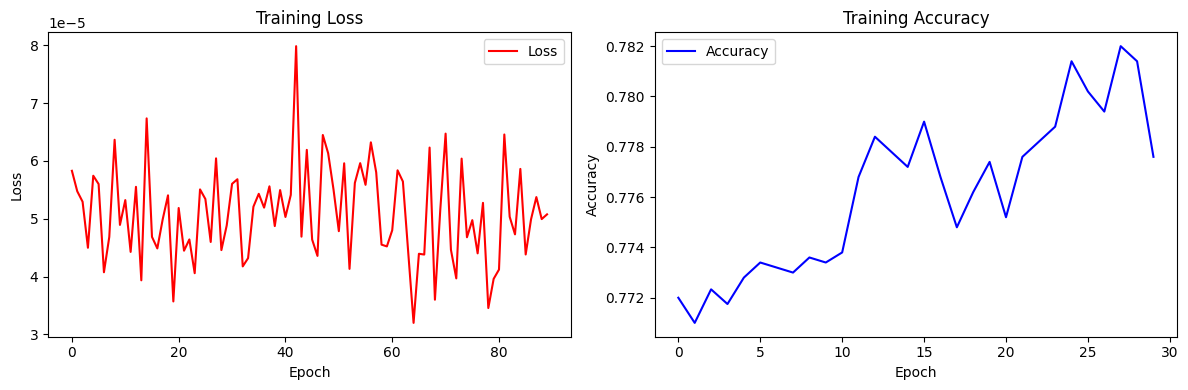

In [66]:
plot_training_metrics(loss_history, smoothed_accuracy)